In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from itertools import islice

In [2]:
df = pd.read_csv("nhldraft.csv")
print (df)

          id  year  overall_pick                 team            player  \
0          1  2022             1   Montreal Canadiens  Juraj Slafkovsky   
1          2  2022             2    New Jersey Devils       Simon Nemec   
2          3  2022             3      Arizona Coyotes      Logan Cooley   
3          4  2022             4       Seattle Kraken      Shane Wright   
4          5  2022             5  Philadelphia Flyers   Cutter Gauthier   
...      ...   ...           ...                  ...               ...   
12245  12246  1963            17  Toronto Maple Leafs       Jim McKenny   
12246  12247  1963            18   Montreal Canadiens      Glen Shirton   
12247  12248  1963            19        Boston Bruins         Jim Blair   
12248  12249  1963            20     New York Rangers  Campbell Alleson   
12249  12250  1963            21  Toronto Maple Leafs      Gerry Meehan   

      nationality position   age  to_year  \
0              SK       LW  18.0      NaN   
1        

### Data Cleansing

In [3]:
# Fill all missing column values with zeroes so that calculations can be successfully executed
df.fillna(0, inplace=True)

# Remove all draft years from df that have not been updated to present day: End at 2019, 'id' 665
# Remove all draft years with less than 100 total picks: Start at 1970, 'id' 12044
# Use 'id' column to filter df using above criteria
filtered_df = df[(df['id'] >= 665) & (df['id'] <= 12044)]
filtered_df.shape[0]
print(filtered_df)

          id  year  overall_pick                team           player  \
664      665  2019             1   New Jersey Devils      Jack Hughes   
665      666  2019             2    New York Rangers      Kaapo Kakko   
666      667  2019             3  Chicago Blackhawks       Kirby Dach   
667      668  2019             4  Colorado Avalanche      Bowen Byram   
668      669  2019             5   Los Angeles Kings    Alex Turcotte   
...      ...   ...           ...                 ...              ...   
12039  12040  1970           111     St. Louis Blues     Mike Lampman   
12040  12041  1970           112     St. Louis Blues      Jeff Rotsch   
12041  12042  1970           113     St. Louis Blues        Al Calver   
12042  12043  1970           114     St. Louis Blues  Gerry MacDonald   
12043  12044  1970           115     St. Louis Blues    Gerald Haines   

      nationality position   age  to_year  \
664            US        C  18.0   2022.0   
665            FI       RW  18.0 

## Making The League

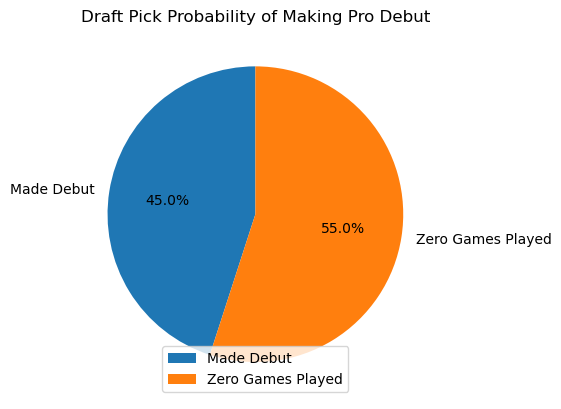

In [4]:
# Calculate the Probability of a Draft Pick Making Their Pro Debut
# Count the number of players that never make their debut, zero games count
# Subtract zero games count from total player count to find number of players that made their debut
# Divide number of players that made their debut by total player count
zero_games_count = filtered_df['games_played'].value_counts()[0]
total_player_count = filtered_df.shape[0]
made_debut_count = total_player_count - zero_games_count

labels = ["Made Debut", "Zero Games Played"]
values = [made_debut_count, zero_games_count]
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Draft Pick Probability of Making Pro Debut")
plt.legend(loc="lower center")
plt.show()
fig.savefig('draft_pick_probability_of_making_pro_debut.png')

- Less than half of draft picks selected end up making their pro debut

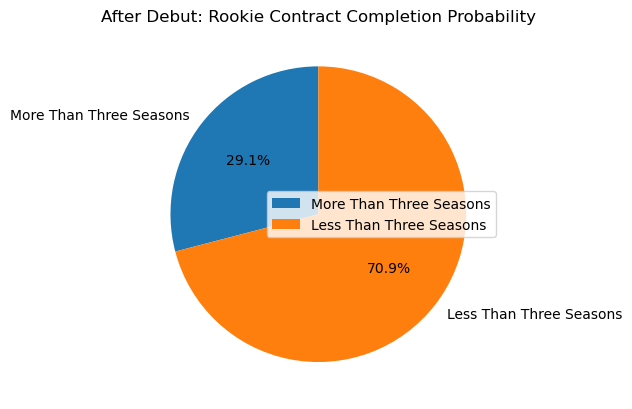

In [5]:
# After Debut: Calculate the Probability of Playing 3+ Seasons/NHL Standard Rookie Contract
three_season_count = filtered_df[filtered_df['games_played'] > 246].shape[0]

labels = ["More Than Three Seasons", "Less Than Three Seasons"]
values = [three_season_count, made_debut_count]
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("After Debut: Rookie Contract Completion Probability")
plt.legend(loc="center right")
plt.show()
fig.savefig('after_debut_rookie_contract_completion_probability.png')

- Of the less than 50% of draft picks that debut, less than one third play out their rookie contract

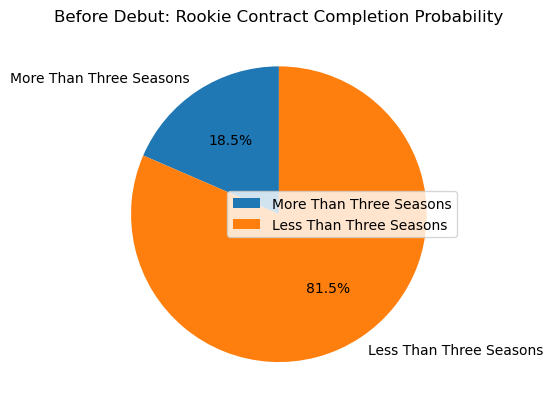

In [6]:
# Calculate the Probability of a Pre-Debut Draft Pick Playing 3+ Seasons/NHL Standard Rookie Contract Length
# Count the number of players that have played 3+ seasons, 1 season is 82 games, 82 x 3 = 246
# Count the number of players that have played less than 3 seasons
three_season_count = filtered_df[filtered_df['games_played'] >= 246].shape[0]
less_than_three_season_count = filtered_df[filtered_df['games_played'] < 246].shape[0]

labels = ["More Than Three Seasons", "Less Than Three Seasons"]
values = [three_season_count, less_than_three_season_count]
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Before Debut: Rookie Contract Completion Probability")
plt.legend(loc="center right")
plt.show()
fig.savefig('before_debut_rookie_contract_completion_probability.png')

- Of all draft picks selected, less than one fifth play out their rookie contract

## Draft Pick Debut Rate - Team by Team

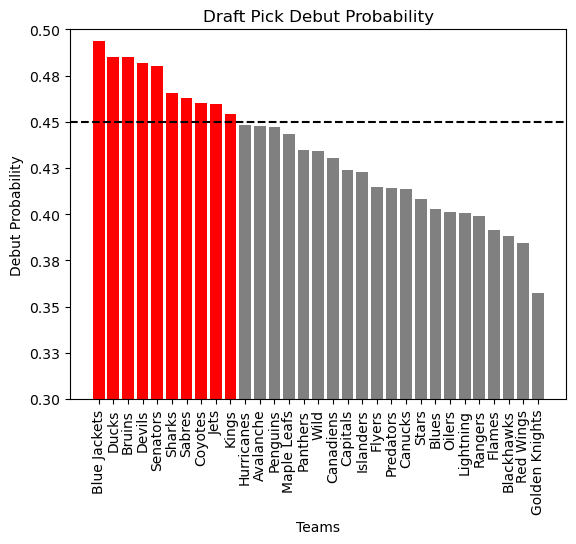

In [7]:
# Compare Team by Team Draft Pick Debut Rate

# Create dictionary list to reference team by team name
teams_dict = {
    "Ducks": "Anaheim Ducks",
    "Coyotes": "Arizona Coyotes",
    "Bruins": "Boston Bruins",
    "Sabres": "Buffalo Sabres",
    "Flames": "Calgary Flames",
    "Hurricanes": "Carolina Hurricanes",
    "Blackhawks": "Chicago Blackhawks",
    "Avalanche": "Colorado Avalanche",
    "Blue Jackets": "Columbus Blue Jackets",
    "Stars": "Dallas Stars",
    "Red Wings": "Detroit Red Wings",
    "Oilers": "Edmonton Oilers",
    "Panthers": "Florida Panthers",
    "Kings": "Los Angeles Kings",
    "Wild": "Minnesota Wild",
    "Canadiens": "Montreal Canadiens",
    "Predators": "Nashville Predators",
    "Devils": "New Jersey Devils",
    "Islanders": "New York Islanders",
    "Rangers": "New York Rangers",
    "Senators": "Ottawa Senators",
    "Flyers": "Philadelphia Flyers",
    "Penguins": "Pittsburgh Penguins",
    "Sharks": 'San Jose Sharks',
    'Blues': 'St. Louis Blues',
    'Lightning': 'Tampa Bay Lightning',
    'Maple Leafs': 'Toronto Maple Leafs',
    'Canucks': 'Vancouver Canucks',
    'Golden Knights': 'Vegas Golden Knights',
    'Capitals': 'Washington Capitals',
    'Jets': 'Winnipeg Jets'
}

# Count the total number of draft picks made on a team by team basis
def teams_total_pick_count(filtered_df, team, teams_dict):
    team_pick_count = {}
    for team_name, abbreviation in teams_dict.items():
        filt_df = filtered_df[filtered_df[team].str.contains(abbreviation)]
        team_pick_count[team_name] = filt_df[team].str.contains(abbreviation).sum()
    return team_pick_count

result_teams_total_pick_count = teams_total_pick_count(filtered_df, "team", teams_dict)

# Count the total number of draft picks that debuted on a team by team basis
def teams_debut_count(filtered_df, team, teams_dict):
    team_pick_count = {}
    for team_name, abbreviation in teams_dict.items():
        filt_df = filtered_df[filtered_df[team].str.contains(abbreviation)]
        filt_df = filt_df[filt_df['games_played'] > 1.0]
        team_pick_count[team_name] = filt_df[team].str.contains(abbreviation).sum()
    return team_pick_count

result_teams_debut_count = teams_debut_count(filtered_df, "team", teams_dict)

# Calculate each team's Debut Rate i.e. their debut count divided by pick count
def debut_rate(result_teams_debut_count, result_teams_total_pick_count):
    team_debut_rate = {}
    for team_name in result_teams_debut_count.keys():
        if team_name in result_teams_total_pick_count:
            team_debut_rate[team_name] = result_teams_debut_count[team_name] / result_teams_total_pick_count[team_name]
    return team_debut_rate

result_teams_debut_rate = debut_rate(result_teams_debut_count, result_teams_total_pick_count)

# Sort in descending order
sorted_teams_debut_rate = dict(sorted(result_teams_debut_rate.items(), key=lambda item: item[1], reverse=True))
teams_names_debut = list(sorted_teams_debut_rate.keys())
debut_rate_values = list(sorted_teams_debut_rate.values())

# Calculate the historic league average of a draft pick debuting as reference point
historic_league_average = made_debut_count / total_player_count

# Assign colors to the top 10 values and leave the rest grey
top_10_values_debut = debut_rate_values[:10]
debut_colors = ['red' if value in top_10_values_debut else 'grey' for value in debut_rate_values]

fig = plt.figure()
plt.bar(teams_names_debut, debut_rate_values, color=debut_colors)
plt.xlabel('Teams')
plt.xticks(rotation=90)
plt.ylim(0.3, 0.5)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.ylabel('Debut Probability')
plt.title('Draft Pick Debut Probability')
plt.axhline(y=historic_league_average, color='black', linestyle='--')
fig.savefig('team_by_team_draft_pick_debut_probability.png', bbox_inches='tight')
plt.show()

## Rookie Contract Completion Rate - Team by Team

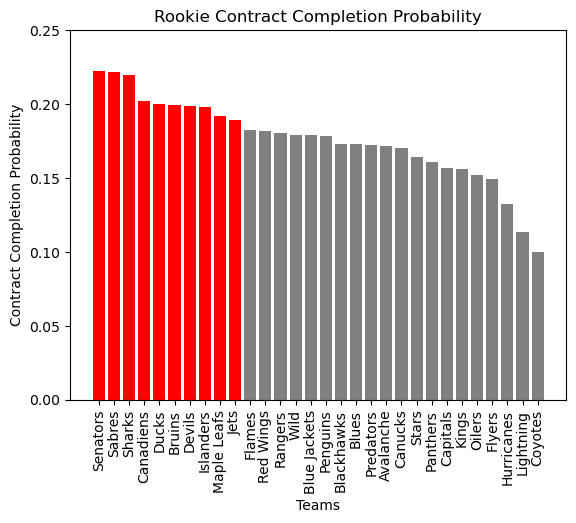

In [8]:
# Compare Team by Team Draft Pick Rookie Contract Completion Success: Games Played >= 264

# Count the total number of draft picks that played more than 3 seasons/264 games
def team_3yr_success_count(filtered_df, team, teams_dict):
    team_pick_count = {}
    for team_name, abbreviation in teams_dict.items():
        filt_df = filtered_df[filtered_df[team].str.contains(abbreviation)]
        filt_df = filt_df[filt_df['games_played'] >= 264]
        team_pick_count[team_name] = filt_df[team].str.contains(abbreviation).sum()
    return team_pick_count

result_team_3yr_success_count = team_3yr_success_count(filtered_df, "team", teams_dict)

# Calculate the rookie contract completion rate by didviding team 3 year success count by team total pick count
def contract_completion(result_team_3yr_success_count, result_teams_total_pick_count):
    team_contract = {}
    for team_name in result_team_3yr_success_count.keys():
        if team_name in result_teams_total_pick_count:
            team_contract[team_name] = result_team_3yr_success_count[team_name] / result_teams_total_pick_count[team_name]
    return team_contract

result_teams_contract_completion = contract_completion(result_team_3yr_success_count, result_teams_total_pick_count)

# Sort in descending order and remove teams with zero values
sorted_teams_contract_completion = dict(sorted(result_teams_contract_completion.items(), key=lambda item: item[1], reverse=True))
zeros_filtered_contract_completion = {key: value for key, value in sorted_teams_contract_completion.items() if value != 0}

teams_contract_completion = list(zeros_filtered_contract_completion.keys())
teams_values_contract_completion = list(zeros_filtered_contract_completion.values())

# Assign colors to the top 10 values and leave the rest grey
top_10_values_rookie = teams_values_contract_completion[:10]
rookie_colors = ['red' if value in top_10_values_rookie else 'grey' for value in teams_values_contract_completion]

fig = plt.figure()
plt.bar(teams_contract_completion, teams_values_contract_completion, color=rookie_colors)
plt.xlabel('Teams')
plt.xticks(rotation=90)
plt.ylim(0.0, 0.25)
plt.ylabel('Contract Completion Probability')
plt.title('Rookie Contract Completion Probability')
fig.savefig('team_by_team_rookie_contract_completion_probability.png', bbox_inches='tight')
plt.show()

## Rookie Contract Completion: In-House Player Development

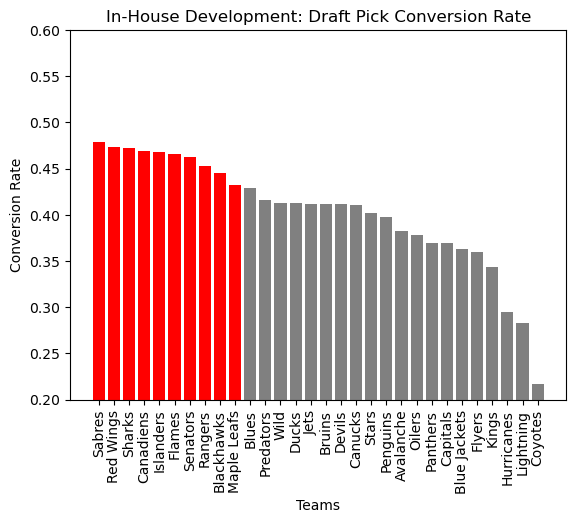

In [9]:
# Compare Rooking Contract Success Rate vs. Debut Success Rate on a Team by Team Basis

# Calculate Team by Team 3 Year Success Conversion Rate, divide 3 year success count by debut success count
def conversion_rate (result_team_3yr_success_count, result_teams_debut_count):
    team_conversion_rate = {}
    for team_name in result_team_3yr_success_count.keys():
        if team_name in result_teams_debut_count:
            team_conversion_rate[team_name] = result_team_3yr_success_count[team_name] / result_teams_debut_count[team_name]
    return team_conversion_rate

result_conversion_rate = conversion_rate(result_team_3yr_success_count, result_teams_debut_count)

# Sort in descending order and remove teams with zero values
sorted_teams_conversion_rate = dict(sorted(result_conversion_rate.items(), key=lambda item: item[1], reverse=True))
zeros_filtered_conversion_rate = {key: value for key, value in sorted_teams_conversion_rate.items() if value != 0}

team_names_conversion_rate = list(zeros_filtered_conversion_rate.keys())
team_conversion_rate_values = list(zeros_filtered_conversion_rate.values())

top_10_values_conversion_rate = team_conversion_rate_values[:10]

# Assign colors to the top 10 values and leave the rest grey
conversion_rate_colors = ['red' if value in top_10_values_conversion_rate else 'grey' for value in team_conversion_rate_values]

fig = plt.figure()
plt.bar(team_names_conversion_rate, team_conversion_rate_values, color = conversion_rate_colors)
plt.xlabel('Teams')
plt.xticks(rotation=90)
plt.ylim(0.2, 0.6)
plt.ylabel('Conversion Rate')
plt.title('In-House Development: Draft Pick Conversion Rate')
fig.savefig('team_by_team_draft_pick_conversion_rate.png', bbox_inches='tight')
plt.show()

## Insights

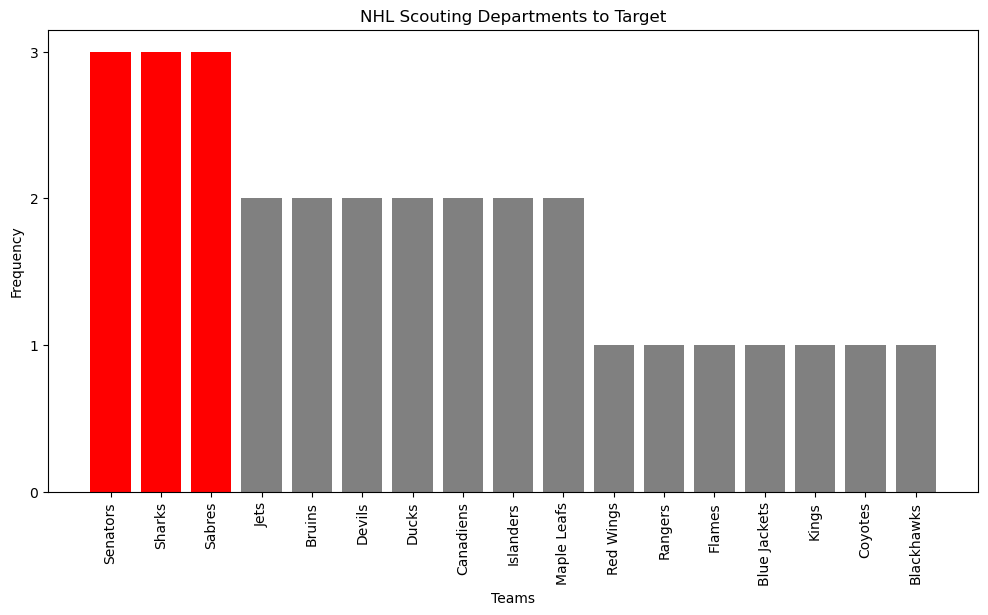

The NHL teams with the top scouting departments to target are:
['Senators' 'Sharks' 'Sabres']


In [10]:
# Determine the teams that are most frequently found amongst the Top 10 for each of the preceding graphs

# Combine all graph lists together so an overall Top 10 list can be extracted
top_10_combined = []
top_10_combined.extend(sorted_teams_debut_rate)
top_10_combined.extend(zeros_filtered_contract_completion)
top_10_combined.extend(zeros_filtered_conversion_rate)

# Extract the first ten elements from each graph's list and find the mode
combined_top_10 = list(islice(sorted_teams_debut_rate, 10)) + list(islice(zeros_filtered_contract_completion, 10)) + list(islice(zeros_filtered_conversion_rate, 10))
top_10_array = np.array(combined_top_10)
top_10_counts = pd.value_counts(top_10_array)
max_count = top_10_counts.max()
teams_to_target = top_10_counts[top_10_counts == max_count].index.values

# Assign colors to the teams to target and leave the rest grey
teams_to_target_colors = ['red' if value in teams_to_target else 'grey' for value in top_10_counts.index.values]

# Visualize the mode

fig = plt.figure(figsize=(12, 6))
plt.bar(top_10_counts.index, top_10_counts.values, color = teams_to_target_colors)
plt.xlabel('Teams')
plt.ylabel('Frequency')
plt.title('NHL Scouting Departments to Target')
plt.xticks(rotation=90)
plt.yticks([0, 1, 2, 3])
fig.savefig('nhl_scouting_departments_to_target.png', bbox_inches='tight')
plt.show()

print("The NHL teams with the top scouting departments to target are:")
print(teams_to_target)

In [11]:
echo "# Python---NHL-Draft" >> README.md
git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin https://github.com/jasonweinberg/Python---NHL-Draft.git
git push -u origin main

SyntaxError: invalid syntax (148014695.py, line 1)